- npz파일 로딩

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = np.load('data/cats_and_dogs.npz')

In [3]:
len(data)

4

In [4]:
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']

In [5]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2000, 224, 224, 3)
(1000, 224, 224, 3)
(2000,)
(1000,)


- 검증용 데이터셋 분리시켜주기

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  random_state=5
                                                 )

In [8]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(1500, 224, 224, 3)
(500, 224, 224, 3)
(1500,)
(500,)


### CNN 모델링

In [9]:
from tensorflow.keras import Sequential
# Conv2D : 2차원 데이터(ex 이미지), Conv3D : 3차원 데이터(ex 영상)
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

In [10]:
# 신경망 구조 설계
cat_dog_model = Sequential()

# 1. 특성 추출부(Conv - 특징이 되는 정보를 추출)
cat_dog_model.add(Conv2D(input_shape = (224,224,3),
                         # 필터(돋보기)의 개수 → 추출하는 특징의 개수를 설정
                         filters = 64,
                         # 필터 크기 설정
                         kernel_size = (5,5),
                         # same : 원본 데이터의 크기에 맞게 알아서 패딩을 적용
                         # valid : 패딩 적용 X
                         padding = 'same',
                         # 필터로 합성곱 연산을 진행시 건너뛰는 크기를 지정(행,열)
                         strides = (3,3),
                         activation = 'relu'
                        ))
# 과대적합 방지를 위해 20%의 뉴런들을 학습시키지 않음
cat_dog_model.add(Dropout(0.2))

# 2. 특성 추출부(Pooling - 불필요한 정보를 삭제)
# pool_size : 디폴트 값은2 → 2 x 2 풀링 필터
cat_dog_model.add(MaxPooling2D(pool_size=2,
                               strides = (2,2)
                              ))

# 3. MLP층에 넣어주기!
cat_dog_model.add(Flatten())   # 추출된 특징들을 자동적으로 펴줌
cat_dog_model.add(Dense(256, activation='relu'))
cat_dog_model.add(Dense(128, activation='relu'))
cat_dog_model.add(Dense(32, activation='relu'))

cat_dog_model.add(Dense(1, activation='sigmoid'))

cat_dog_model.summary()

# Conv 첫 층의 파라미터 개수는 입력필터수 * 필터크기 * 채널수 + 필터수(b값)    64 * 25 * 3 + 64

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 75, 75, 64)        4864      
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 37, 37, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 87616)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               22429952  
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4

In [11]:
# 학습 및 평가 방법 설정
cat_dog_model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['acc']
             )

In [12]:
h = cat_dog_model.fit(X_train, y_train,
              validation_data = (X_val, y_val),
              batch_size=128, 
              epochs = 50
             )

Epoch 1/50
12/12 [==============================] - 10s 842ms/step - loss: 241.3702 - acc: 0.4900 - val_loss: 2.1917 - val_acc: 0.4840
Epoch 2/50
12/12 [==============================] - 10s 824ms/step - loss: 1.0725 - acc: 0.5173 - val_loss: 0.7169 - val_acc: 0.5120
Epoch 3/50
12/12 [==============================] - 10s 800ms/step - loss: 0.6743 - acc: 0.5647 - val_loss: 0.7008 - val_acc: 0.5160
Epoch 4/50
12/12 [==============================] - 10s 867ms/step - loss: 0.6315 - acc: 0.6313 - val_loss: 0.7066 - val_acc: 0.5800
Epoch 5/50
12/12 [==============================] - 10s 799ms/step - loss: 0.4634 - acc: 0.7880 - val_loss: 0.7703 - val_acc: 0.5840
Epoch 6/50
12/12 [==============================] - 10s 801ms/step - loss: 0.2960 - acc: 0.8860 - val_loss: 1.3803 - val_acc: 0.5460
Epoch 7/50
12/12 [==============================] - 9s 782ms/step - loss: 0.1290 - acc: 0.9533 - val_loss: 1.4678 - val_acc: 0.5400
Epoch 8/50
12/12 [==============================] - 9s 787ms/step - 

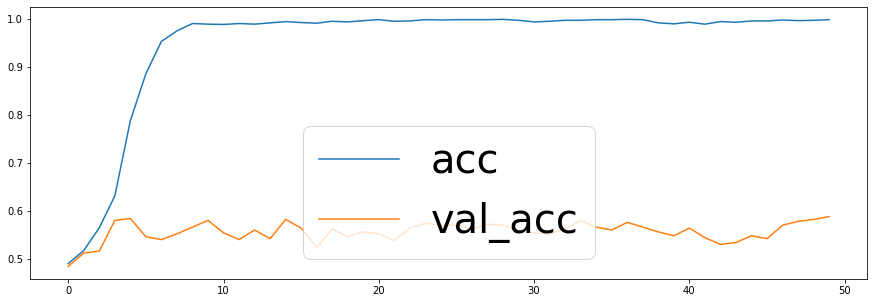

In [13]:
plt.figure(figsize=(15,5))

plt.plot(h.history['acc'],
         label='acc'
        )

plt.plot(h.history['val_acc'],
         label='val_acc'
        )

plt.legend(prop={'size':40}, loc="lower center")
plt.show()

- 개, 고양이 사진의 다양함과 데이터의 규모에 비해서 Conv층과 Pooling층이 너무 간단해서 제대로 된 결과가 나오지 않음

### VGG16 모델을 개, 고양이 이미지 데이터 분류에 활용해보자!

In [14]:
from tensorflow.keras.applications import VGG16

In [15]:
# include_top = False : 불러온 모델의 MLP층을 사용하지 않음(특성추출방식)
# → 기존 이미지넷 대회에서는 1000가지의 이미지를 분류했고 VGG16모델도
#    거기에 맞춰져 있음, 우리는 개, 고양이 2진분류 모델을 만들기 때문에
#    MLP층을 다르게 설정해줘야 함!

# weights = imagenet :  이미지넷에서 잘 학습된 가중치(w)를 그대로 가져옴

vgg16 = VGG16(include_top = False,
              weights = 'imagenet',
              input_shape= (224,224,3)
             )

In [16]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [17]:
# 신경망 설계
transfer_model = Sequential()

# VGG16모델의 특성추출부를 활용
transfer_model.add(vgg16)

# MLP층 쌓기
transfer_model.add(Flatten())
transfer_model.add(Dense(256, activation='relu'))
transfer_model.add(Dense(128, activation='relu'))
transfer_model.add(Dense(64, activation='relu'))
transfer_model.add(Dense(1, activation='sigmoid'))

transfer_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 21,178,689
Trainable params: 21,178,689
Non-trainable params: 0
__________________________________________

In [18]:
# 학습 및 평가 방법 설정
transfer_model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['acc']
             )

In [19]:
h1 = transfer_model.fit(X_train, y_train,
              validation_data = (X_val, y_val),
              batch_size=128, 
              epochs = 20
             )

Epoch 1/20
12/12 [==============================] - 515s 43s/step - loss: 60.7077 - acc: 0.5107 - val_loss: 0.7008 - val_acc: 0.4800
Epoch 2/20
12/12 [==============================] - 496s 41s/step - loss: 0.7069 - acc: 0.4767 - val_loss: 0.7002 - val_acc: 0.4840
Epoch 3/20
12/12 [==============================] - 494s 41s/step - loss: 0.6961 - acc: 0.4787 - val_loss: 0.6932 - val_acc: 0.5020
Epoch 4/20
12/12 [==============================] - 523s 44s/step - loss: 0.6904 - acc: 0.5147 - val_loss: 0.6893 - val_acc: 0.5680
Epoch 5/20
12/12 [==============================] - 509s 42s/step - loss: 0.6856 - acc: 0.5613 - val_loss: 0.6823 - val_acc: 0.5660
Epoch 6/20
12/12 [==============================] - 505s 42s/step - loss: 0.6792 - acc: 0.5787 - val_loss: 0.6892 - val_acc: 0.5500
Epoch 7/20
12/12 [==============================] - 488s 41s/step - loss: 0.6901 - acc: 0.5473 - val_loss: 0.6882 - val_acc: 0.5080
Epoch 8/20
12/12 [==============================] - 488s 41s/step - loss: 0

### 학습이 제대로 되고 있지 않음
- MLP층에서 발생된 오차가 역전파를 통해서 vgg16 모델 앞단부로 전달되면서 사전에 잘 학습되어져 있던 w,b값들을 많이 손실시켰음
- 사전 학습된 w,b 값이 변경되지 않도록 vgg16모델의 일부층들을 동결시켜놓고 추가로 학습을 진행해보자!

In [20]:
# 동결시킬 층을 확인하기 위해 vgg16모델의 층(layer)들의 명칭을 확인해보자
for layer in vgg16.layers:
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [21]:
# 신경망 설계
transfer_model1 = Sequential()

# 미세조정 방식 적용
# vgg16모델에서 마지막 Conv층을 제외하고 학습이 불가능하도록 동결시켜보자!
# -----------------------------------------------
for layer in vgg16.layers:
    if layer.name=='block5_conv3':
        layer.trainable = True
    else :
        layer.trainable = False
        
# -----------------------------------------------
# VGG16모델의 특성추출부를 활용
transfer_model1.add(vgg16)

# MLP층 쌓기
transfer_model1.add(Flatten())
transfer_model1.add(Dense(256, activation='relu'))
transfer_model1.add(Dense(128, activation='relu'))
transfer_model1.add(Dense(64, activation='relu'))
transfer_model1.add(Dense(1, activation='sigmoid'))

transfer_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 21,178,689
Trainable params: 8,823,809
Non-trainable params: 12,354,880
__________________________________

In [22]:
transfer_model1.compile(loss='binary_crossentropy',
                        optimizer = 'Adam',
                        metrics=['acc']
                       )

In [23]:
h1 = transfer_model1.fit(X_train, y_train,
                        epochs=20,
                        batch_size=128
                       )

Epoch 1/20
12/12 [==============================] - 92s 8s/step - loss: 0.6721 - acc: 0.6047
Epoch 2/20
12/12 [==============================] - 92s 8s/step - loss: 0.5915 - acc: 0.6860
Epoch 3/20
12/12 [==============================] - 92s 8s/step - loss: 0.5765 - acc: 0.7020
Epoch 4/20
12/12 [==============================] - 93s 8s/step - loss: 0.5791 - acc: 0.6887
Epoch 5/20
12/12 [==============================] - 93s 8s/step - loss: 0.5651 - acc: 0.7000
Epoch 6/20
12/12 [==============================] - 92s 8s/step - loss: 0.5362 - acc: 0.7213
Epoch 7/20
12/12 [==============================] - 92s 8s/step - loss: 0.5277 - acc: 0.7227
Epoch 8/20
12/12 [==============================] - 93s 8s/step - loss: 0.5123 - acc: 0.7420
Epoch 9/20
12/12 [==============================] - 92s 8s/step - loss: 0.4974 - acc: 0.7460
Epoch 10/20
12/12 [==============================] - 92s 8s/step - loss: 0.4977 - acc: 0.7393
Epoch 11/20
12/12 [==============================] - 92s 8s/step - lo

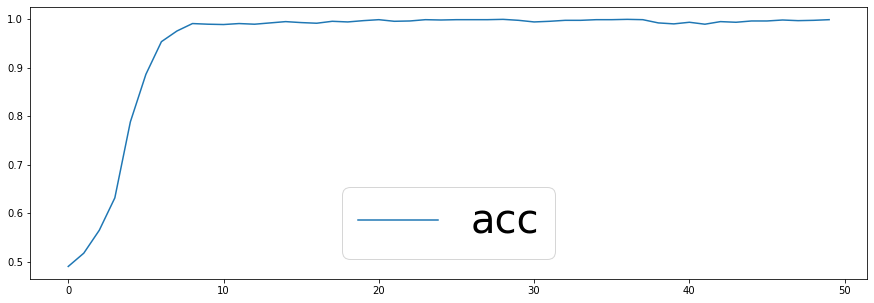

In [24]:
plt.figure(figsize=(15,5))

plt.plot(h.history['acc'],
         label='acc'
        )

plt.legend(prop={'size':40}, loc="lower center")
plt.show()

In [25]:
transfer_model1.evaluate(X_test, y_test)

32/32 [==============================] - 62s 2s/step - loss: 0.9984 - acc: 0.6490


[0.9984209537506104, 0.6489999890327454]

#### 전이학습 모델을 불러와서 특성추출방식과 미세조정방식을 모두 적용했더니 정확도가 훨씬 향상되는 것을 확인할 수 있음